In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm, metrics, linear_model, neural_network
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Absenteeism_at_work_AAA/Absenteeism_at_work.csv', sep=';')

Attribute Information:

1. Individual identification (ID)
2. Reason for absence (ICD).
Absences attested by the International Code of Diseases (ICD) stratified into 21 categories (I to XXI) as follows:

I Certain infectious and parasitic diseases  
II Neoplasms  
III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism  
IV Endocrine, nutritional and metabolic diseases  
V Mental and behavioural disorders  
VI Diseases of the nervous system  
VII Diseases of the eye and adnexa  
VIII Diseases of the ear and mastoid process  
IX Diseases of the circulatory system  
X Diseases of the respiratory system  
XI Diseases of the digestive system  
XII Diseases of the skin and subcutaneous tissue  
XIII Diseases of the musculoskeletal system and connective tissue  
XIV Diseases of the genitourinary system  
XV Pregnancy, childbirth and the puerperium  
XVI Certain conditions originating in the perinatal period  
XVII Congenital malformations, deformations and chromosomal abnormalities  
XVIII Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified  
XIX Injury, poisoning and certain other consequences of external causes  
XX External causes of morbidity and mortality  
XXI Factors influencing health status and contact with health services.

And 7 categories without (CID) patient follow-up (22), medical consultation (23), blood donation (24), laboratory examination (25), unjustified absence (26), physiotherapy (27), dental consultation (28).
3. Month of absence
4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
5. Seasons
6. Transportation expense
7. Distance from Residence to Work (kilometers)
8. Service time
9. Age
10. Work load Average/day 
11. Hit target
12. Disciplinary failure (yes=1; no=0)
13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
14. Son (number of children)
15. Social drinker (yes=1; no=0)
16. Social smoker (yes=1; no=0)
17. Pet (number of pet)
18. Weight
19. Height
20. Body mass index
21. Absenteeism time in hours (target)

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
ID                                 740 non-null int64
Reason for absence                 740 non-null int64
Month of absence                   740 non-null int64
Day of the week                    740 non-null int64
Seasons                            740 non-null int64
Transportation expense             740 non-null int64
Distance from Residence to Work    740 non-null int64
Service time                       740 non-null int64
Age                                740 non-null int64
Work load Average/day              740 non-null float64
Hit target                         740 non-null int64
Disciplinary failure               740 non-null int64
Education                          740 non-null int64
Son                                740 non-null int64
Social drinker                     740 non-null int64
Social smoker                      740 non-null int64
Pet                          

In [4]:
new_cols = list()
for col in data.columns:
    words = col.lower().split()
    new_cols.append('_'.join(words))

data.columns = new_cols

In [5]:
column_name_mapping = {'distance_from_residence_to_work': 'work_distance', 'work_load_average/day': 'work_load',
                       'absenteeism_time_in_hours': 'absenteeism_time', 'body_mass_index': 'bmi'}
data.rename(columns=column_name_mapping, inplace=True)

data['reason_for_absence'] = data['reason_for_absence'].astype('category')

According to the original paper that used this dataset, the data was collected for every month from July 2007 to July 2010. However, the dataset doesn't contain a year attribute. But, because the data are sorted in chronological, I'll reconstruct a year attribute based on the ordering of the data.

The original paper: Martiniano, A & Pinto Ferreira, Ricardo & Sassi, Renato & Affonso, Carlos. (2012). Application of a neuro fuzzy network in prediction of absenteeism at work. Iberian Conference on Information Systems and Technologies, CISTI. 1-4.

In [6]:
year = 2007
year_list = list()
firstm_row = True
for index, row in data.iterrows():
    if row['month_of_absence'] == 1 and firstm_row:
        year += 1
        firstm_row = False
    elif row['month_of_absence'] == 2 and (not firstm_row):
        firstm_row = True
        
    year_list.append(year)
    
data['year'] = year_list

null_months = list(data[data['month_of_absence'] == 0].index)
data.loc[null_months, 'month_of_absence'] = 7

data['recorded_date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_of_absence'].astype(str))

In [7]:
data.iloc[:,:10].head(7)

,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,transportation_expense,work_distance,service_time,age,work_load
0,11,26,7,3,1,289,36,13,33,239.554
1,36,0,7,3,1,118,13,18,50,239.554
2,3,23,7,4,1,179,51,18,38,239.554
3,7,7,7,5,1,279,5,14,39,239.554
4,11,23,7,5,1,289,36,13,33,239.554
5,3,23,7,6,1,179,51,18,38,239.554
6,10,22,7,6,1,361,52,3,28,239.554


In [8]:
data.iloc[:,10:].head(7)

,hit_target,disciplinary_failure,education,son,social_drinker,social_smoker,pet,weight,height,bmi,absenteeism_time,year,recorded_date
0,97,0,1,2,1,0,1,90,172,30,4,2007,2007-07-01
1,97,1,1,1,1,0,0,98,178,31,0,2007,2007-07-01
2,97,0,1,0,1,0,0,89,170,31,2,2007,2007-07-01
3,97,0,1,2,1,1,0,68,168,24,4,2007,2007-07-01
4,97,0,1,2,1,0,1,90,172,30,2,2007,2007-07-01
5,97,0,1,0,1,0,0,89,170,31,2,2007,2007-07-01
6,97,0,1,1,1,0,4,80,172,27,8,2007,2007-07-01


# Replication of the original study

This section mainly focuses on the relationship between reasons for absence and the duration of absence, which was the original study about. The section, however, is still incomplete. The process of fuzzification for model training will be added later.

In [9]:
sns.set()

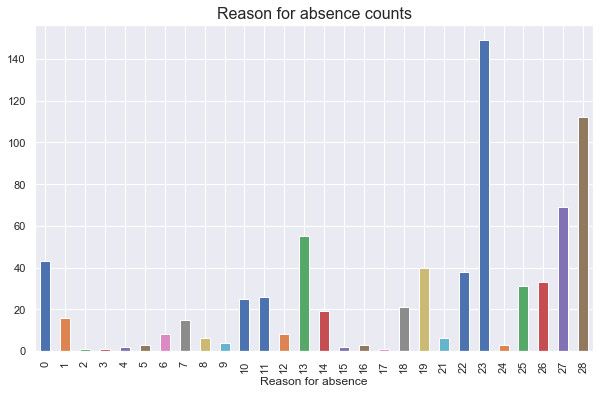

In [10]:
reason_counts = data.groupby(['reason_for_absence'])[['reason_for_absence']].count()
reason_counts.columns = ['count']

plt.figure(figsize = (10, 6))

reason_ax = reason_counts.unstack().plot.bar()
reason_ax.set_xlabel('Reason for absence')
reason_ax.set_xticklabels(reason_counts.index)
reason_ax.set_title('Reason for absence counts', fontsize=16)

plt.show()

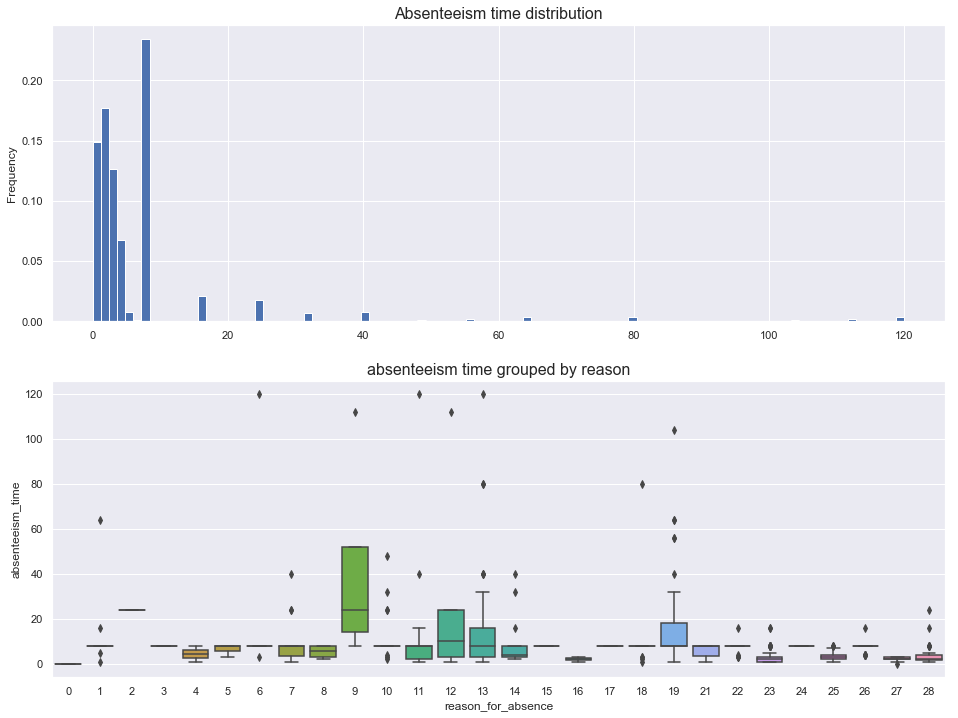

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

ax1 = data['absenteeism_time'].plot.hist(bins=100, density=True, ax=axes[0])
ax1.set_title('Absenteeism time distribution', fontsize=16)

ax2 = sns.boxplot(x='reason_for_absence', y='absenteeism_time', data=data, ax=axes[1])
ax2.set_title('absenteeism time grouped by reason', fontsize=16)
plt.show()

One feature that's directly related to absenteeism time is reason for the absence even though the data is a bit sparse. In the original study, the researchers built a neuro fuzzy network to predict the value of absenteeism time for each employee using this feature alone. The authors used the one-hot-encoding to represent the input at first. One-hot-encoding is a representational vector that use 0 indicate the absence of features and 1 indicate their presence. Then the authors convert the one-hot-encodings using gaussian membership functions then feed the results into a multilayer perceptron.

In [12]:
# constructing a dataframe to further visualize
# the relationship between reason_for_absence and absenteeism_time

reason_df = data[['id', 'reason_for_absence', 'absenteeism_time']]
reason_df = reason_df.groupby(['id', 'reason_for_absence']).agg(['count', 'sum'])
reason_df = reason_df.reset_index()
reason_df.columns = ['id', 'reason_for_absence'] + ['_'.join(col) for col in reason_df.columns[2:]]
reason_df['reason_for_absence'] = pd.to_numeric(reason_df['reason_for_absence'])
reason_df.head()

,id,reason_for_absence,absenteeism_time_count,absenteeism_time_sum
0,1,0,1,0
1,1,1,1,8
2,1,7,1,3
3,1,11,1,4
4,1,13,3,25


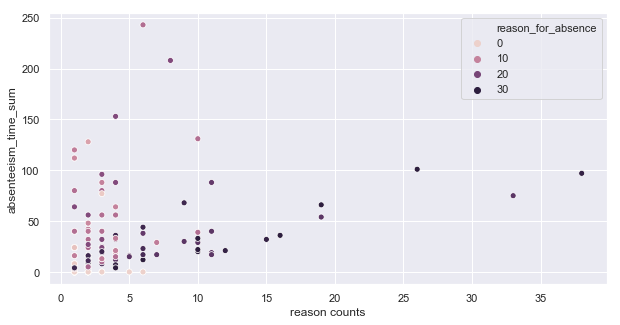

In [13]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x='absenteeism_time_count', y='absenteeism_time_sum', hue='reason_for_absence', data=reason_df)
plt.xlabel('reason counts')
plt.show()

In [14]:
# creating dummy variables to represent one-hot-encoding input

reason_v = data[['id', 'reason_for_absence', 'absenteeism_time', 'recorded_date']]
reason_v = pd.get_dummies(reason_v, columns=['reason_for_absence'])

If we go ahead and train the model using the traditional one-hot-encoding representation to train our model, it will merely result in a value mapping function (imagine calculating mean of absenteeism time of each reason for absence and use the mean alone to predict the absenteeism time). Hence, I'll group the data by employee id to allow the interaction between each feature that might result in better generalizability. However, this will result in we have much less data to train our model.

In [15]:
train_data = reason_v[reason_v['recorded_date'] < '2010-04-01']
test_data = reason_v[reason_v['recorded_date'] >= '2010-04-01']

X_train = train_data.drop(columns='recorded_date').groupby(['id']).sum()
X_test = test_data.drop(columns='recorded_date').groupby(['id']).sum()

y_train, y_test = X_train['absenteeism_time'], X_test['absenteeism_time']
X_train, X_test = X_train.iloc[:, 1:], X_test.iloc[:, 1:]

## Artificial neural network

In [16]:
hidden_sizes = [(i, j+1) for i in np.arange(5, 11) for j in range(3)]
param_grid = dict(hidden_layer_sizes=hidden_sizes)

# replicating the parameter setting from the paper
ann = neural_network.MLPRegressor(learning_rate_init=0.1, max_iter=65, momentum=0.7, random_state=123)

ann_gs = GridSearchCV(ann, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4)

ann_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=65, momentum=0.7,
       nesterovs_momentum=True, power_t=0.5, random_state=123,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3), (8, 1), (8, 2), (8, 3), (9, 1), (9, 2), (9, 3), (10, 1), (10, 2), (10, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [17]:
print(ann_gs.best_params_)
print(ann_gs.best_score_)
y_pred = ann_gs.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_pred))

{'hidden_layer_sizes': (6, 3)}
-62.86229962527071
27.019772682672667


## Ridge regression (Linear regression with l2 regularization)

In [18]:
param_grid = dict(alpha = np.arange(1,10))

r = linear_model.Ridge(max_iter=100, random_state=123)
r_gs = GridSearchCV(r, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4)

r_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, random_state=123, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [19]:
print(r_gs.best_params_)
y_pred = r_gs.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_pred))

{'alpha': 9}
20.821774892012783


In [20]:
test_df = reason_v.drop(columns='id').groupby('recorded_date').sum()
feature_cols = test_df.columns[1:]
X_train, X_test = test_df.loc[:'2010-03-01', feature_cols], test_df.loc['2010-03-01':, feature_cols]

In [21]:
test_df.index

DatetimeIndex(['2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2008-01-01', '2008-02-01',
               '2008-03-01', '2008-04-01', '2008-05-01', '2008-06-01',
               '2008-07-01', '2008-08-01', '2008-09-01', '2008-10-01',
               '2008-11-01', '2008-12-01', '2009-01-01', '2009-02-01',
               '2009-03-01', '2009-04-01', '2009-05-01', '2009-06-01',
               '2009-07-01', '2009-08-01', '2009-09-01', '2009-10-01',
               '2009-11-01', '2009-12-01', '2010-01-01', '2010-02-01',
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01'],
              dtype='datetime64[ns]', name='recorded_date', freq=None)

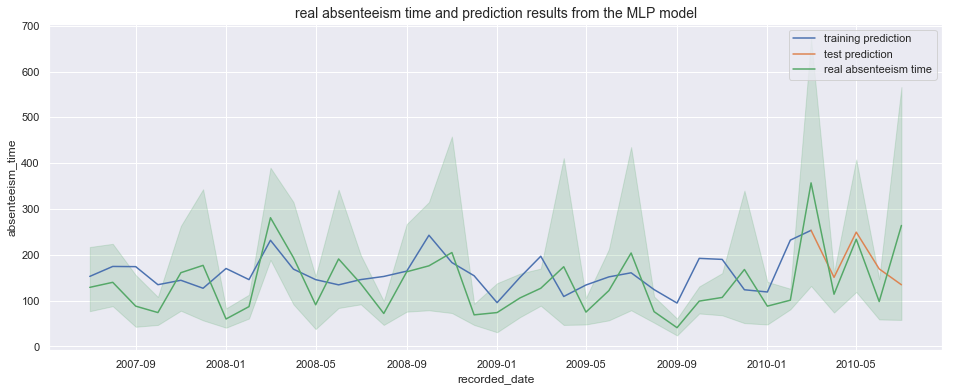

In [22]:
train_preds = ann_gs.predict(X_train)
train_pred_df = pd.DataFrame(data=np.transpose([test_df[:'2010-03-01'].index, train_preds]),
                             columns=['date', 'prediction'])

test_preds = ann_gs.predict(X_test)
test_pred_df = pd.DataFrame(data=np.transpose([test_df['2010-03-01':].index, test_preds]),
                            columns=['date', 'prediction'])

fig = plt.figure(figsize=(16,6))

sns.lineplot(x='date', y='prediction', estimator=None, data=train_pred_df)
sns.lineplot(x='date', y='prediction', estimator=None, data=test_pred_df)
sns.lineplot(x='recorded_date', y='absenteeism_time', estimator='sum', data=data)
plt.title('real absenteeism time and prediction results from the MLP model', fontsize=14)
plt.legend(('training prediction', 'test prediction', 'real absenteeism time'))

plt.show()

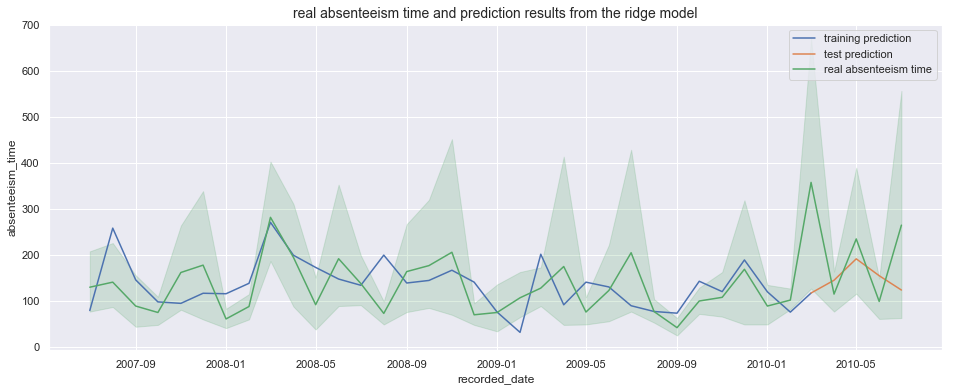

In [23]:
train_preds = r_gs.predict(X_train)
train_pred_df = pd.DataFrame(data=np.transpose([test_df[:'2010-03-01'].index, train_preds]),
                             columns=['date', 'prediction'])

test_preds = r_gs.predict(X_test)
test_pred_df = pd.DataFrame(data=np.transpose([test_df['2010-03-01':].index, test_preds]),
                            columns=['date', 'prediction'])

fig = plt.figure(figsize=(16,6))

sns.lineplot(x='date', y='prediction', estimator=None, data=train_pred_df)
sns.lineplot(x='date', y='prediction', estimator=None, data=test_pred_df)
sns.lineplot(x='recorded_date', y='absenteeism_time', estimator='sum', data=data)
plt.title('real absenteeism time and prediction results from the ridge model', fontsize=14)
plt.legend(('training prediction', 'test prediction', 'real absenteeism time'))

plt.show()

The results of both models are quite far from perfect, especially the ridge model seems to underfit even the training data. Again, the models were trained with quite a limited dataset and features.

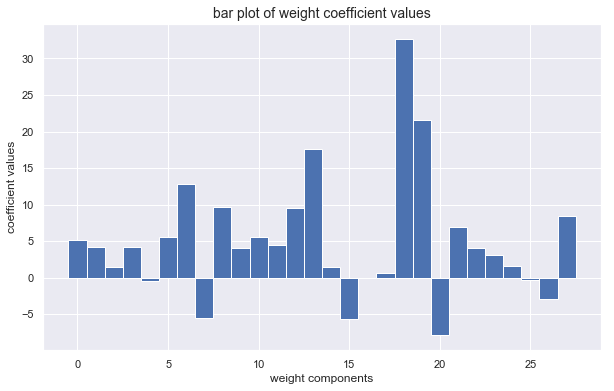

In [24]:
fig = plt.figure(figsize=(10, 6))

inds = np.arange(r_gs.best_estimator_.coef_.shape[0])
vals = r_gs.best_estimator_.coef_

plt.bar(inds, vals, width=1, align='center')
plt.xlabel('weight components')
plt.ylabel('coefficient values')
plt.title('bar plot of weight coefficient values', fontsize=14)
plt.show()

Here's the visualization of learned coefficients of the ridge model, and we can see which reasons (13, 18, and 19) that the model think would result in high absenteeism time. We can go back and look at the boxplot of absenteeism time and reason for absence above. We will see that the reasons that the ridge model assigns big weights to are those that have outliers (or just very high absenteeism time).

# Exploratory data analysis

This dataset might seem to contain an ample sample size. However, a lot of data records come from the same person, so they're not entirely independent. I'll try to take this characteristic into account while performing data analysis.

In [25]:
print('total number of distinct employees in the dataset = {}'.format(data['id'].nunique()))

total number of distinct employees in the dataset = 36


## Effects of drinking and smoking

It's well-studied that drinking and smoking can cause several diseases. As a result, it can result in absence of employees. Even though the policy to restrain employees from drinking and smoking might be merely impossible, we can implement a policy that can indirectly reduce their effects and study their effects to take their effects into account when we explore other variables.

In [26]:
print(data['social_drinker'].value_counts())
print(data['social_smoker'].value_counts())

1    420
0    320
Name: social_drinker, dtype: int64
0    686
1     54
Name: social_smoker, dtype: int64


In [27]:
density_function = lambda x: x/float(x.sum())

In [29]:
data['social_drinker'] = data['social_drinker'].map(lambda x: 'drinker' if x == 1 else 'non_drinker').astype('category')
data['social_smoker'] = data['social_smoker'].map(lambda x: 'smoker' if x == 1 else 'non_smoker').astype('category')

I merged 'social_drinker' and 'social_smoker' features together to see if their interaction would result in a different effect.

Then I want to check if anyone change their 'drink_smoke' category over during the time of data collection.

In [30]:
ds_dist_counts = data.groupby(['id']).agg({'social_drinker': pd.Series.nunique, 'social_smoker': pd.Series.nunique})
ds_dist_counts[(ds_dist_counts['social_drinker'] > 1) | (ds_dist_counts['social_smoker'] > 1)]

,social_drinker,social_smoker
id,,
29,2,1


In [31]:
data.loc[data['id'] == 29, ['reason_for_absence', 'age', 'recorded_date',
                            'social_drinker', 'social_smoker', 'absenteeism_time']]

,reason_for_absence,age,recorded_date,social_drinker,social_smoker,absenteeism_time
51,0,28,2007-09-01,non_drinker,non_smoker,0
592,28,41,2010-02-01,drinker,non_smoker,2
675,19,41,2010-05-01,drinker,non_smoker,3
681,14,41,2010-05-01,drinker,non_smoker,8
683,22,41,2010-05-01,drinker,non_smoker,8


I found that the employee 29 has 2 drink_smoke categories, so I checked the subject's data in the dataset to see when the subject changed his/her drink_smoke status. However, from a simple inspection, we can see the discrepancy in the age attribute. His/her age when the subject did neither drink nor smoke is entirely different from when the subject becomes a social drinker. I speculate that there was a misfiling of id during the data collection. Therefore, I'll treat the record with age 28 as a different person and assign a new id to him/her.

In [32]:
data.loc[51, 'id'] = 37

Now we can be certain that each person belongs to only 1 drink_smoke category, and there're no transitions in this category during the data collection period.

In [33]:
print(data.groupby('id').agg({'social_drinker': 'first'})['social_drinker'].value_counts())
print(data.groupby('id').agg({'social_smoker': 'first'})['social_smoker'].value_counts())

drinker        19
non_drinker    18
Name: social_drinker, dtype: int64
non_smoker    30
smoker         7
Name: social_smoker, dtype: int64


We probably rather see the effect of "drink_smoke" feature on the population level than the magnitude of the effect on the individual level, so I'll count each reason for absence only once for each employee.

In [34]:
grouped_drink = data.groupby(['social_drinker', 'reason_for_absence']).agg({'id': pd.Series.nunique})
grouped_smoke = data.groupby(['social_smoker', 'reason_for_absence']).agg({'id': pd.Series.nunique})

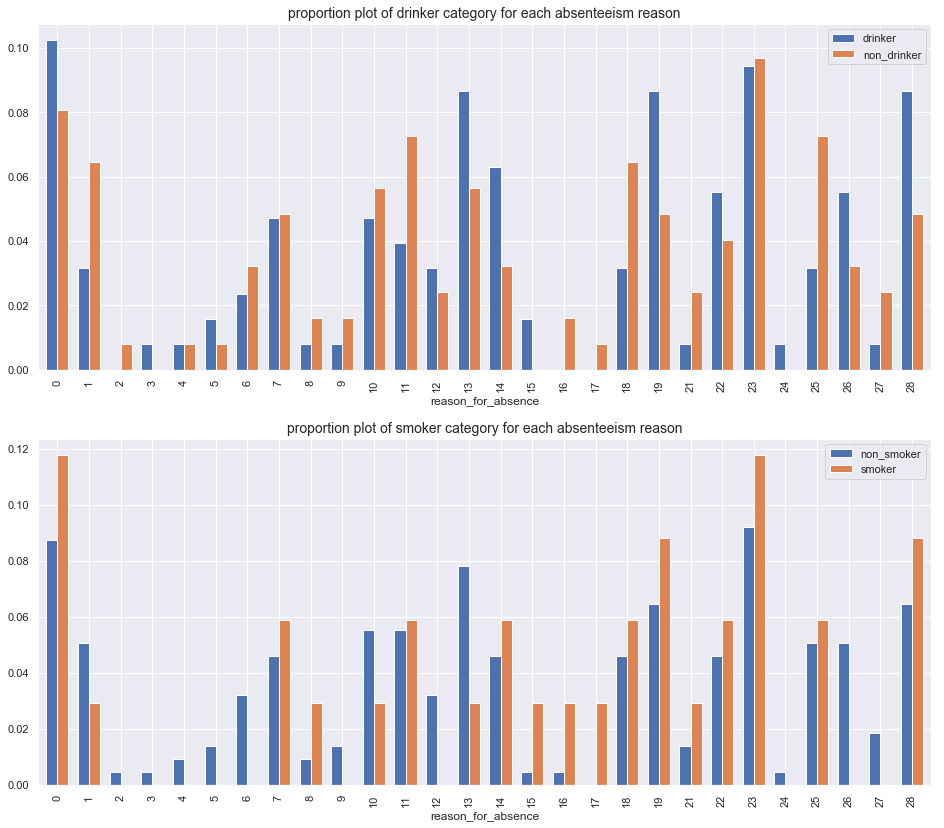

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(14)

tmp_table = grouped_drink.unstack('social_drinker').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[0])
axes[0].set_title('proportion plot of drinker category for each absenteeism reason', fontsize=14)

tmp_table = grouped_smoke.unstack('social_smoker').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[1])
axes[1].set_title('proportion plot of smoker category for each absenteeism reason', fontsize=14)

plt.show()

The above 2 plots show the proportion (probability) of people absent due to a certain reason given whether an employee is a social drinker or not, or a social smoker or not. For example, ~12% of social smokers are absent because of reason 23 (medical consultation) and reason 0 (no absence). This visualization allows us to compare the proportion of social drinkers and social smokers to non social drinkers and non social smokers while not affected by the number of people belong to each category. Contrast to my speculation, bigger proportion of non-drinkers and non-smokers are absent due to disease-related reasons including reason 9 and 10 (Diseases of the circulatory system and Diseases of the respiratory system). On the other hand, smokers have bigger proportion of absence due to reason 14 - 23, which includes prenatal issues (14-17), abnormal findings (18), and external causes of sickness (19-21).

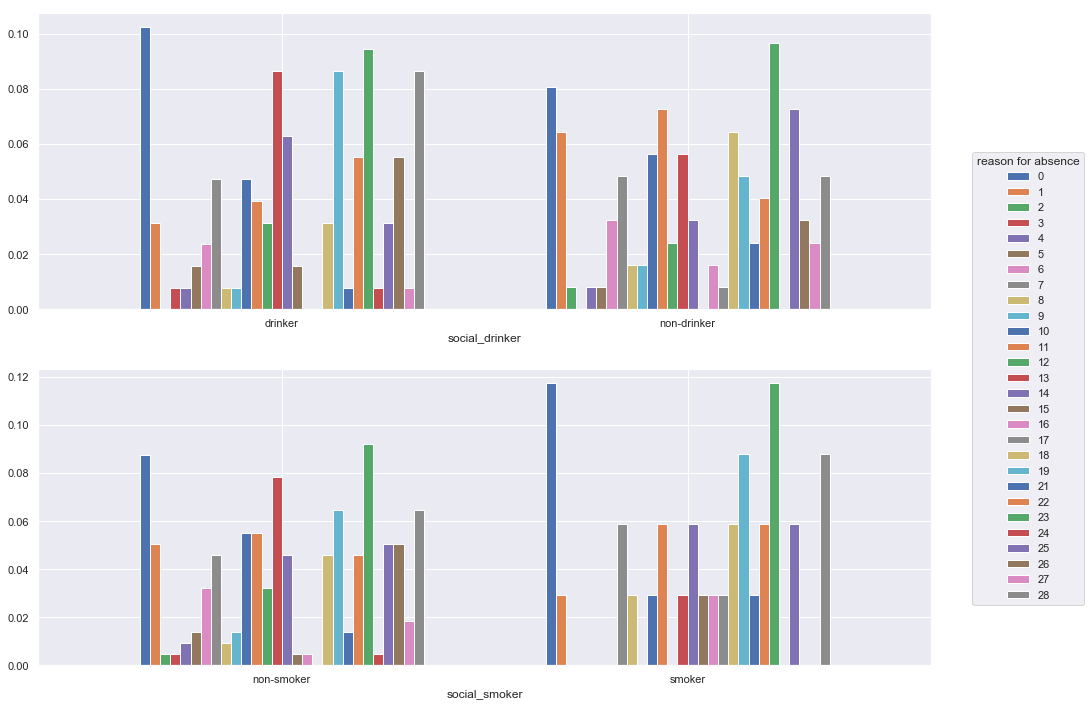

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

tmp_table = grouped_drink.unstack('reason_for_absence').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

ax = tmp_table.apply(density_function, axis=1).plot.bar(width=0.7, ax=axes[0])
ax.set_xticklabels(["drinker", 'non-drinker'], rotation=0)
ax.legend_.remove()

tmp_table = grouped_smoke.unstack('reason_for_absence').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

ax = tmp_table.apply(density_function, axis=1).plot.bar(width=0.7, ax=axes[1])
ax.set_xticklabels(['non-smoker', 'smoker'], rotation=0)
ax.legend(title='reason for absence', bbox_to_anchor=(1.04,1.75), loc="upper left")

plt.show()

Now I changed the perspective by grouping the stacks of proportion based on social_drinker/social_smoker category, so it's easier to see which reason for absence is common among each group. From the plots above, the commonest reason for absence for drinkers is reason 0, which is actually indicate no absence. Next to reason 0, there are reason 23 (medical consultation), 13 (Diseases of the musculoskeletal system and connective tissue), 19 (injury and poisoning by external causes), and 28 (dental consultation). Similarly for smokers, a few most common reasons for absence include reason 0, 23 (medical consultation), 19 (injury and poisoning by external causes), and 23 (dental consultation).

After seeing that drinkers and smokers share some common reasons for absence, we might suspect that they are not entirely independent and have some overlapped samples. So I'll check that by constructing a new attribute called "drink_smoke" that merge them together.

In [60]:
def merge_drink_smoke(row):
    if row['social_drinker'] == 'non_drinker' and row['social_smoker'] == 'non_smoker':
        return 'non-smoker-drinker'
    elif row['social_drinker'] == 'drinker' and row['social_smoker'] == 'non_smoker':
        return 'drinker'
    elif row['social_drinker'] == 'non_drinker' and row['social_smoker'] == 'smoker':
        return 'smoker'
    elif row['social_drinker'] == 'drinker' and row['social_smoker'] == 'smoker':
        return 'smoker-drinker'
    
data['drink_smoke'] = data.apply(merge_drink_smoke, axis=1)

In [62]:
data.groupby('drink_smoke').agg({'id': pd.Series.nunique})

,id
drink_smoke,
drinker,15
non-smoker-drinker,15
smoker,3
smoker-drinker,4


From checking the number of employees in each category of the new attribute, we see that there are not many smokers in the dataset (7 in total). And more than half of the smokers (4 out of 7) are also drinkers. Hence, it makes sense that the proportion of reasons for absence of smokers is similar to the drinker's proportion.

### Visualizing the magnitude of the effect (not grouped by employee id)

If we want to see the actual size of effect of social_drinker and social_smokers categories on each reason for absence, we can just count all the records of each category in the original dataframe to visualize. But we should keep in mind that effects from employees that have many records can dominate the effects from other employees.

In [132]:
rds_group = data.groupby(['reason_for_absence', 'drink_smoke'])['id'].count()
rds_ratio_group = rds_group.groupby('drink_smoke').apply(density_function)

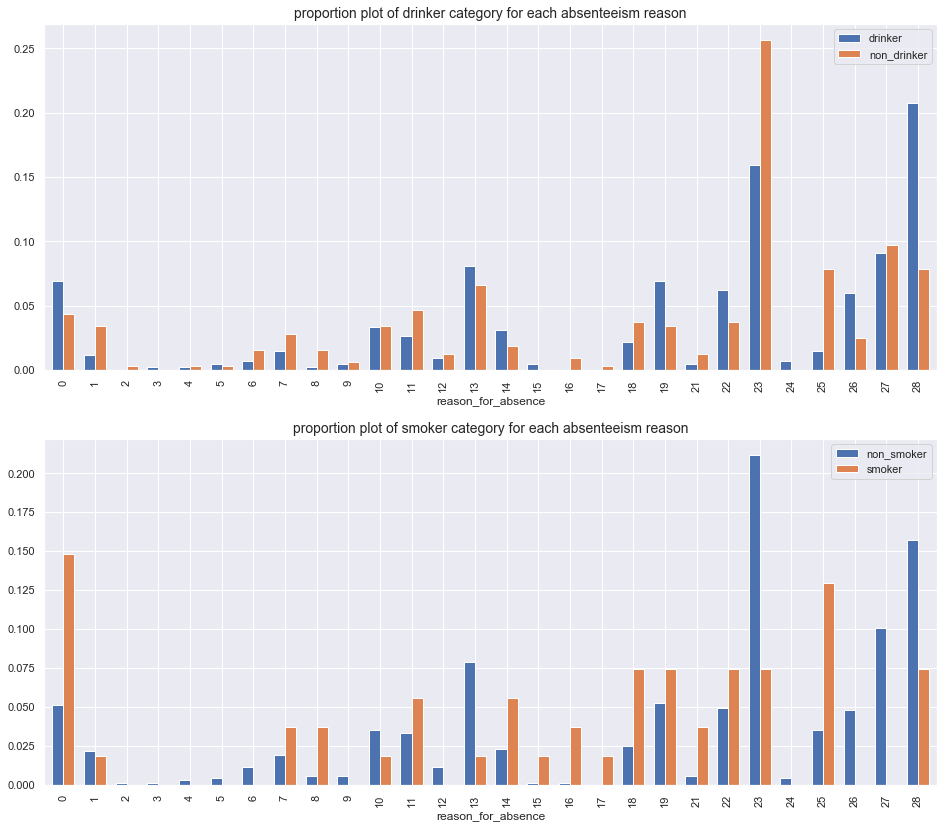

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(14)

count_drink = data.groupby(['social_drinker', 'reason_for_absence']).agg({'id': 'count'})
count_smoke = data.groupby(['social_smoker', 'reason_for_absence']).agg({'id': 'count'})

tmp_table = count_drink.unstack('social_drinker').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[0])
axes[0].set_title('proportion plot of drinker category for each absenteeism reason', fontsize=14)

tmp_table = count_smoke.unstack('social_smoker').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[1])
axes[1].set_title('proportion plot of smoker category for each absenteeism reason', fontsize=14)

plt.show()

This plot shows the proportion (probability) of absences due to a certain reason given whether an employee is a social drinker or not, or a social smoker or not. From the plots, the non-smokers and non-drinkers groups have a lot of absence due to reason 23 (medical consultation), which might indicate that these employees go to see a doctor more regularly than other groups.

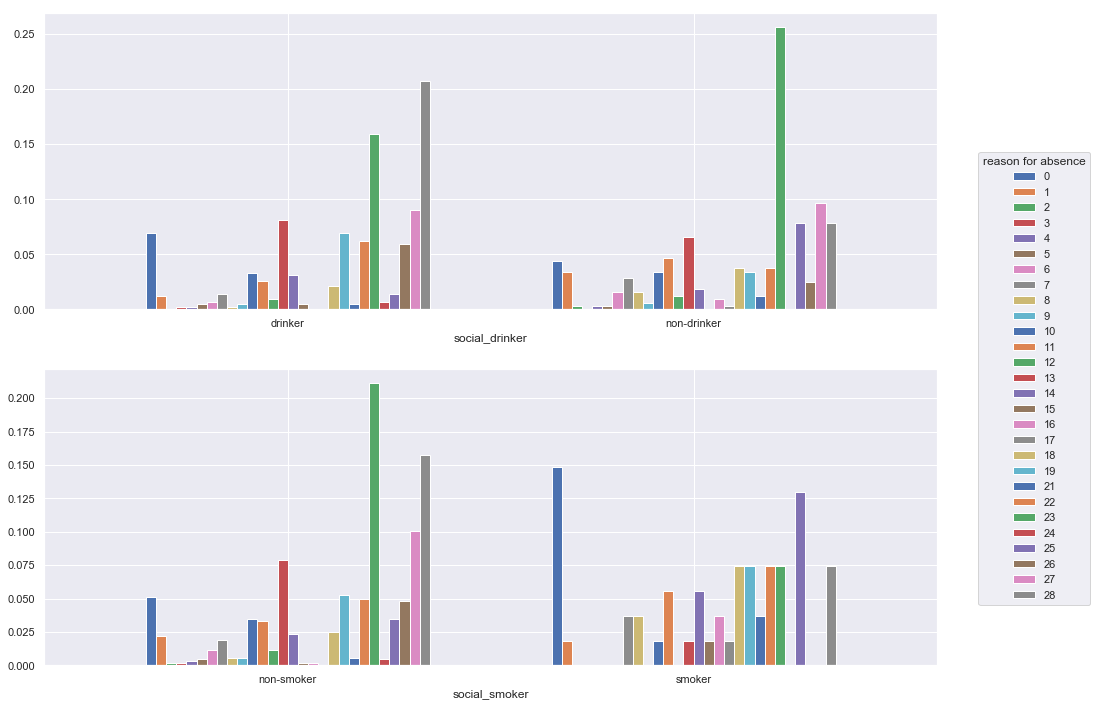

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

tmp_table = count_drink.unstack('reason_for_absence').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

ax = tmp_table.apply(density_function, axis=1).plot.bar(width=0.7, ax=axes[0])
ax.set_xticklabels(["drinker", 'non-drinker'], rotation=0)
ax.legend_.remove()

tmp_table = count_smoke.unstack('reason_for_absence').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

ax = tmp_table.apply(density_function, axis=1).plot.bar(width=0.7, ax=axes[1])
ax.set_xticklabels(['non-smoker', 'smoker'], rotation=0)
ax.legend(title='reason for absence', bbox_to_anchor=(1.04,1.75), loc="upper left")

plt.show()

Again, I changed the perspective by grouping the stacks of proportion based on social_drinker/social_smoker category, so it's easier to see which reason for absence is common among each group. We might notice some changes compared to the plots that used only unique count of each employee. For drinkers, reason 28 (dental consultation) has become the most common reason for absence. For smokers, the most common reason is still reason 0, but the second most common reason now is reason 25 (Pregnancy, childbirth and the puerperium).

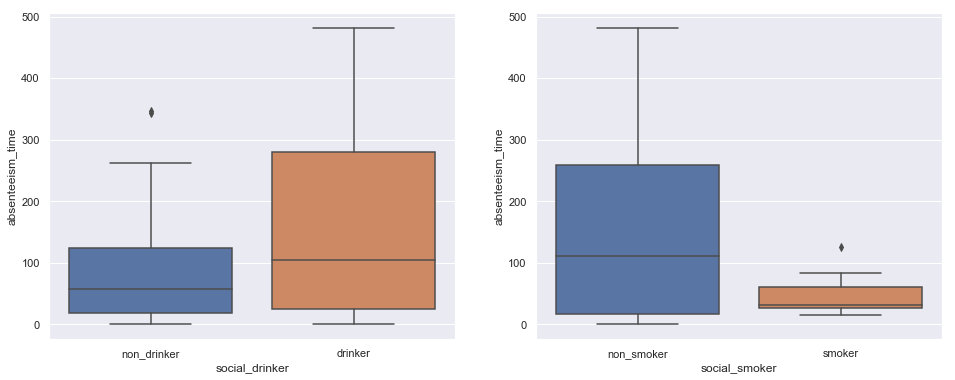

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(6)

d_abstime_df = data.groupby('id').agg({'social_drinker': 'first', 'absenteeism_time': 'sum'})
sns.boxplot(x='social_drinker', y='absenteeism_time', data=d_abstime_df, ax=axes[0])

s_abstime_df = data.groupby('id').agg({'social_smoker': 'first', 'absenteeism_time': 'sum'})
sns.boxplot(x='social_smoker', y='absenteeism_time', data=s_abstime_df, ax=axes[1])

plt.show()

Lastly, I checked direct links between social_drinker/social_smoker and absenteeism time. summing absenteeism time over each employee shows the full effect of social_drinker and social_smoker attributes. If an employee has many absence records resulting high absenteeism time, it indicates the loss in productivity and is shown in the box plot here. From the boxplots above, the highest value of absenteeism time for smokers is lowest compared to the other groups, and smokers also has the narrowest range of absenteeism time (though, it might be due to the small population). But the lowest absenteeism time of this group is also ~8 hours, which means all smokers are absent at least 8 hours. Moreover, from 2 box plots, the box plot of drinkers and non-smokers are very similar to each other, which indicates that employees that have very high absenteeism time are social drinkers but not social smokers.

## Work load average

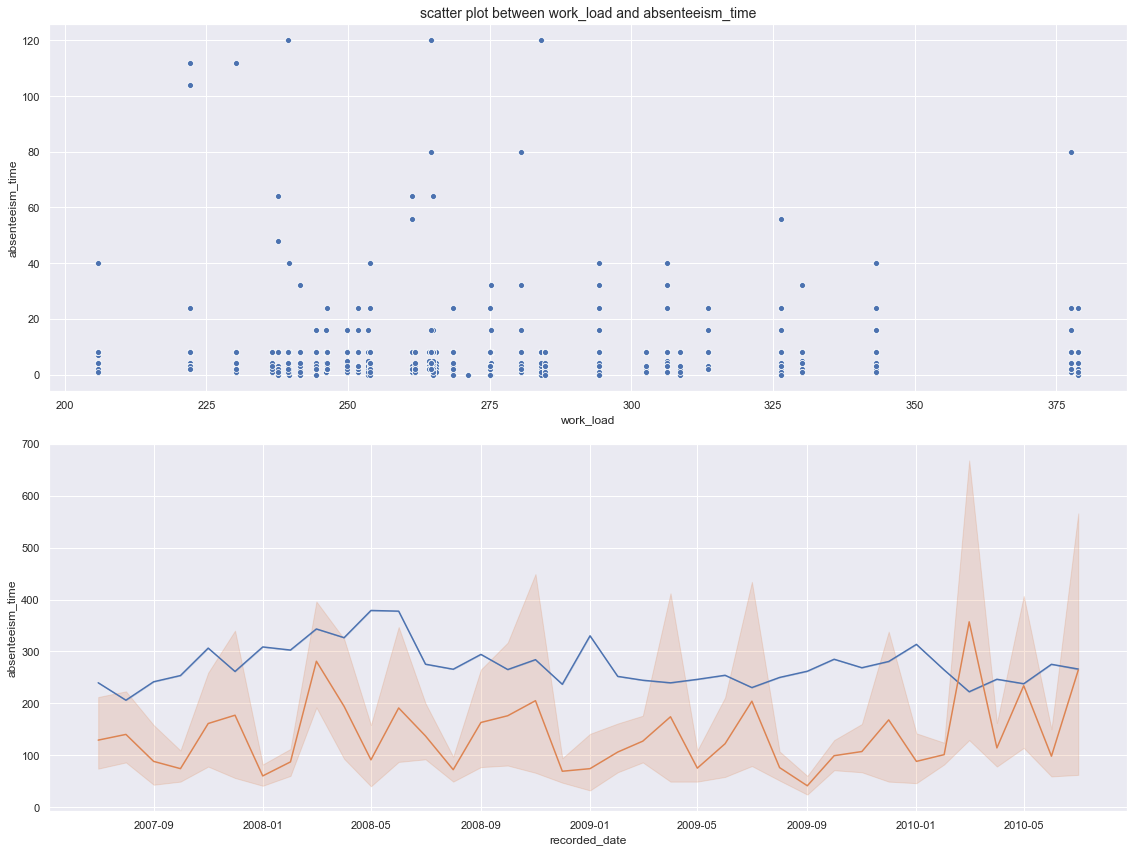

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

sns.scatterplot(x='work_load', y='absenteeism_time', data=data, ax=axes[0])
axes[0].set_title('scatter plot between work_load and absenteeism_time', fontsize=14)


sns.lineplot(x='recorded_date', y='work_load', data=data, ax=axes[1])
sns.lineplot(x='recorded_date', y='absenteeism_time', estimator='sum', data=data, ax=axes[1])

plt.tight_layout()
plt.show()

From the scatter plot, we see almost no correlation between work_load_average and absenteeism time, which might because the distribution of absenteeism time is heavily skewed. Now, when we look at the line plot, we might spot some interesting changing patterns of work load average and absenteeism time. We can notice that in some months, as absenteeism time decreases, the work load average increases and vice versa. These patterns are present in several months including 2007-08, 2007-09, 2007-10, 2008-01, and so on. Even though their magnitudes of change are not fully correlated, it shows a consistent relationship between work load average and absenteeism time.

Nevertheless, it's worth keeping in mind that we don't know the nature of how work load average was measured and documented in the first place.

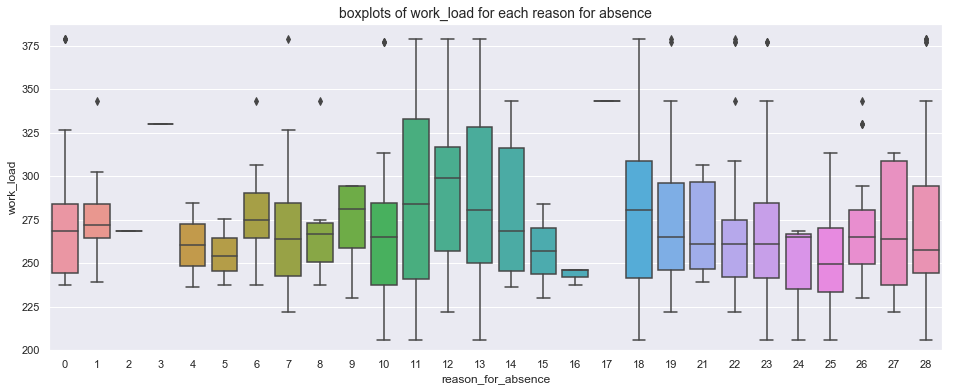

In [71]:
fig = plt.figure(figsize=(16, 6))

ax = sns.boxplot(x='reason_for_absence', y='work_load', data=data)
ax.set_ylim(200)
ax.set_title('boxplots of work_load for each reason for absence', fontsize=14)

plt.show()

There's an interesting variation in work_load_average when grouped by reason for absence.

## Dependents

Here, I'll explore how having children/sons and pets might affect the absence of employees. Again, before I go ahead and perform data analysis, I'll group the data by employee id first to reduce the effects of employees that have many absence records. And, first, I'll make sure that all employees have the same number of sons and pets throughout the data collection period.

In [72]:
dep_dist_counts = data.groupby(['id']).agg({'son': pd.Series.nunique, 'pet': pd.Series.nunique})
dep_dist_counts[(dep_dist_counts['son'] > 1) | (dep_dist_counts['pet'] > 1)]

,son,pet
id,,


Seems like we have no anomalies in these attributes.

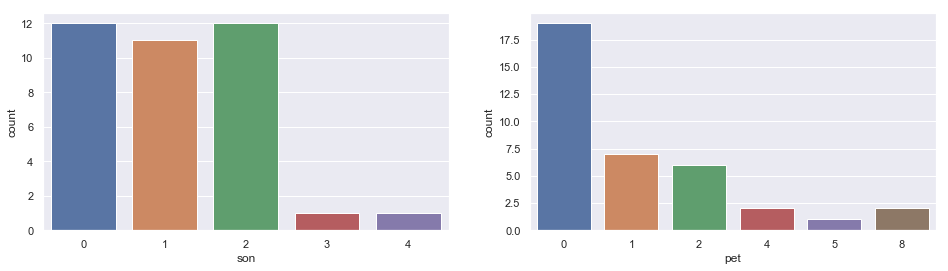

In [73]:
dep_table = data.groupby('id').agg({'son': 'first', 'pet': 'first'})

fig = plt.figure()
fig.set_figwidth(16)

plt.subplot(121)
sns.countplot(x='son', data=dep_table)

plt.subplot(122)
sns.countplot(x='pet', data=dep_table)

plt.show()

First, I checked the distributions of numbers of sons and pets among the employees. As I perform further analyzes, I'll take this into account to reduce the noisy effect of the data. From these 2 bar plots, most employees have 0-2 children and 0 pet.

To simplify the analysis, I'll hypothesize that the numbers of sons and pets do not give us much information. So, I'll categorize them into 2 classes representing them with new attributes 'has_son' and 'has_pet'.

In [74]:
data['has_son'] = data['son'].map(lambda x: 'no_son' if x == 0 else 'has_sons').astype('category')
data['has_pet'] = data['pet'].map(lambda x: 'no_pet' if x == 0 else 'has_pets').astype('category')

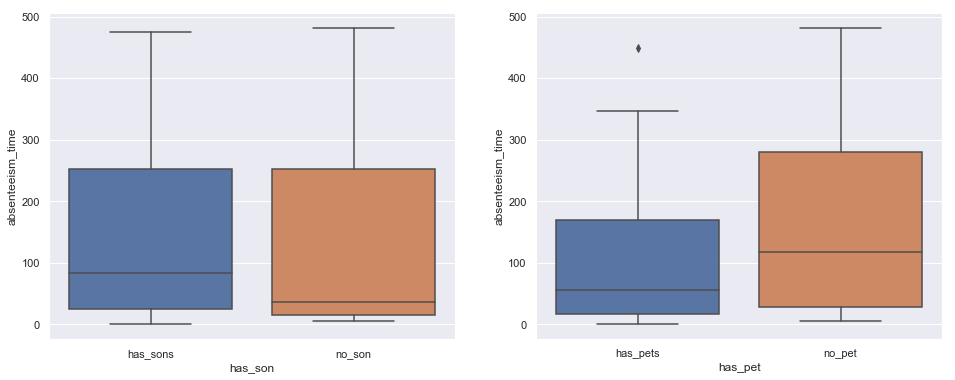

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(6)

hs_abstime_df = data.groupby('id').agg({'has_son': 'first', 'absenteeism_time': 'sum'})
sns.boxplot(x='has_son', y='absenteeism_time', data=hs_abstime_df, ax=axes[0])

hp_abstime_df = data.groupby('id').agg({'has_pet': 'first', 'absenteeism_time': 'sum'})
sns.boxplot(x='has_pet', y='absenteeism_time', data=hp_abstime_df, ax=axes[1])

plt.show()

From the left box plot, whether or not an employee has sons/children has almost no effect on absenteeism time. The right box plot, on the other hand, shows slight difference in absenteeism time between people who own pets and who don't own pets.

In [81]:
grouped_son = data.groupby(['has_son', 'reason_for_absence']).agg({'id': pd.Series.nunique})
grouped_pet = data.groupby(['has_pet', 'reason_for_absence']).agg({'id': pd.Series.nunique})

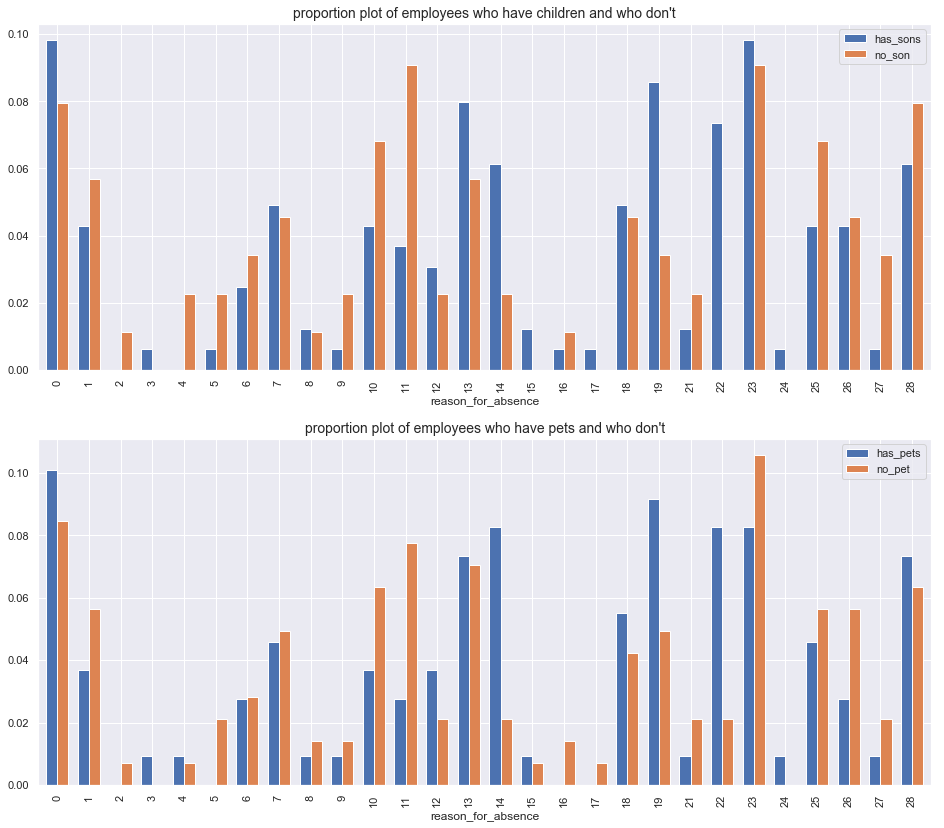

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(14)

tmp_table = grouped_son.unstack('has_son').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[0])
axes[0].set_title("proportion plot of employees who have children and who don't", fontsize=14)

tmp_table = grouped_pet.unstack('has_pet').fillna(value=0)
tmp_table.columns = [col[1] for col in tmp_table.columns]

tmp_table.apply(density_function).plot.bar(width=0.7, ax=axes[1])
axes[1].set_title("proportion plot of employees who have pets and who don't", fontsize=14)

plt.show()